In [9]:
import seaborn as sb
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_absolute_error
import pandas_datareader.data as web
import pandas as pd
import numpy as np
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")
plt.style.use("dark_background")

In [5]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if gpu_devices:
    print("Using GPU")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print("Using CPU")

Using CPU


In [6]:
sb.set_style("whitegrid")
np.random.seed(42)

In [7]:
results_path = Path("results", "multivariate_time_series")
if not results_path.exists():
    results_path.mkdir(parents=True)

In [8]:
df = web.DataReader(["UMCSENT", "IPGMFN"], "fred", "1980", "2019-12").dropna()
df.columns = ["sentiment", "ip"]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480 entries, 1980-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  480 non-null    float64
 1   ip         480 non-null    float64
dtypes: float64(2)
memory usage: 11.2 KB


In [10]:
df.head()

,sentiment,ip
DATE,,
1980-01-01,67.0,46.1102
1980-02-01,66.9,47.1928
1980-03-01,56.5,47.6967
1980-04-01,52.7,46.3082
1980-05-01,51.7,44.9652


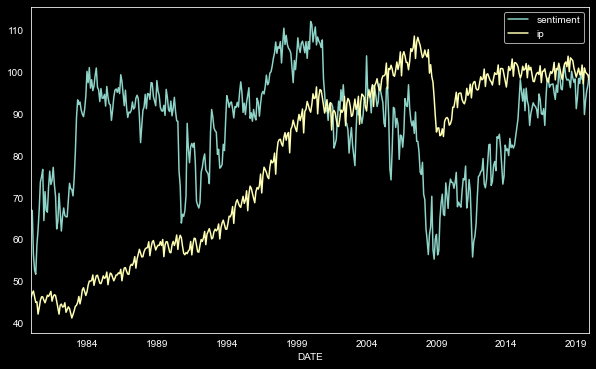

In [25]:
df.plot.line(grid=False, figsize=(10, 6));

Stationarity

In [13]:
df_transformed = (pd.DataFrame({"ip": np.log(df.ip).diff(12), "sentiment": df.sentiment.diff(12)}).dropna())

Scaling

In [14]:
df_transformed = df_transformed.apply(minmax_scale)

변환과정 수행 후에도 데이터가 비정상
=> RNN에 데이터를 넣어도 모델링이 안됨
=> RNN은 앞 뒤 관계를 통해서 미래를 맞춤.
=> RNN을 쓰기 위해서는 앞 뒤 관계가 명확한 데이터를 넣어주어야 한다.

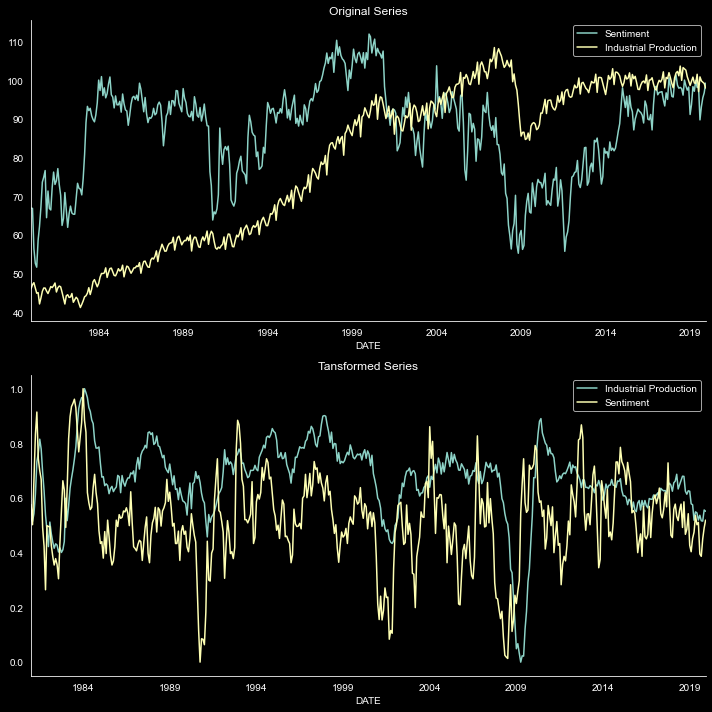

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
columns={"ip": "Industrial Production", "sentiment": "Sentiment"}
df.rename(columns=columns).plot(ax=axes[0], grid=False, title="Original Series")
df_transformed.rename(columns=columns).plot(ax=axes[1], grid=False, title="Tansformed Series")
sb.despine()
fig.tight_layout()
fig.savefig(results_path / "multi_rnn", dpi=300)

In [16]:
df.values.reshape(-1, 12, 2).shape

(40, 12, 2)

In [17]:
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:]
    n = data.shape[0]
    X = np.stack([data[i: j] 
                  for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

In [18]:
window_size = 20

In [19]:
X, y = create_multivariate_rnn_data(df_transformed, window_size=window_size)

In [20]:
X.shape, y.shape

((448, 20, 2), (448, 2))

In [21]:
test_size = 24
train_size = X.shape[0]-test_size

In [22]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [30]:
y_test

,ip,sentiment
DATE,,
2018-01-01,0.624962,0.455611
2018-02-01,0.655947,0.559464
2018-03-01,0.662041,0.577889
2018-04-01,0.687026,0.532663
2018-05-01,0.633190,0.517588
2018-06-01,0.649115,0.556114
2018-07-01,0.664977,0.577889
2018-08-01,0.679929,0.492462
2018-09-01,0.679370,0.586265


In [31]:
X_train.shape, X_test.shape

((424, 20, 2), (24, 20, 2))

In [32]:
K.clear_session()

In [33]:
n_features = output_size = 2

In [34]:
lstm_units = 200
dense_units = 128

In [35]:
rnn = Sequential([
    LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
         input_shape=(window_size, n_features),
         return_sequences=False),
    Dense(dense_units),
    Dense(output_size)
])

In [36]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               162400    
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 188,386
Trainable params: 188,386
Non-trainable params: 0
_________________________________________________________________


In [37]:
rnn.compile(loss="mse", optimizer="RMSProp")

In [41]:
lstm_path = (results_path / "lstm.h5").as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor="val_loss",
                               mode="min",
                               save_best_only=True)

early_stopping = EarlyStopping(monitor="val_loss", 
                              patience=10,
                              restore_best_weights=True)

result = rnn.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=20,
                 shuffle=False,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping, checkpointer],
                 verbose=1)

Epoch 1/100
21/22 [===========================>..] - ETA: 0s - loss: 0.0121
Epoch 1: val_loss improved from inf to 0.00208, saving model to results/multivariate_time_series\lstm.h5
22/22 [==============================] - 1s 67ms/step - loss: 0.0121 - val_loss: 0.0021
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.0111
Epoch 2: val_loss did not improve from 0.00208
22/22 [==============================] - 2s 85ms/step - loss: 0.0111 - val_loss: 0.0028
Epoch 3/100
21/22 [===========================>..] - ETA: 0s - loss: 0.0123
Epoch 3: val_loss did not improve from 0.00208
22/22 [==============================] - 2s 77ms/step - loss: 0.0123 - val_loss: 0.0022
Epoch 4/100
22/22 [==============================] - ETA: 0s - loss: 0.0112
Epoch 4: val_loss did not improve from 0.00208
22/22 [==============================] - 2s 72ms/step - loss: 0.0112 - val_loss: 0.0024
Epoch 5/100
21/22 [===========================>..] - ETA: 0s - loss: 0.0124
Epoch 5: val_loss did 

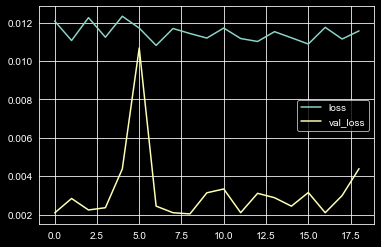

In [42]:
pd.DataFrame(result.history).plot();

In [43]:
y_pred = rnn.predict(X_test)

1/1 [==============================] - 0s 405ms/step


In [44]:
y_pred[3]

array([0.62746656, 0.5275965 ], dtype=float32)

In [45]:
y_pred = pd.DataFrame(rnn.predict(X_test), 
                      columns=y_test.columns, 
                      index=y_test.index)
y_pred.info()

1/1 [==============================] - 0s 38ms/step
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2018-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ip         24 non-null     float32
 1   sentiment  24 non-null     float32
dtypes: float32(2)
memory usage: 384.0 bytes


In [46]:
test_mae = mean_absolute_error(y_pred, y_test)

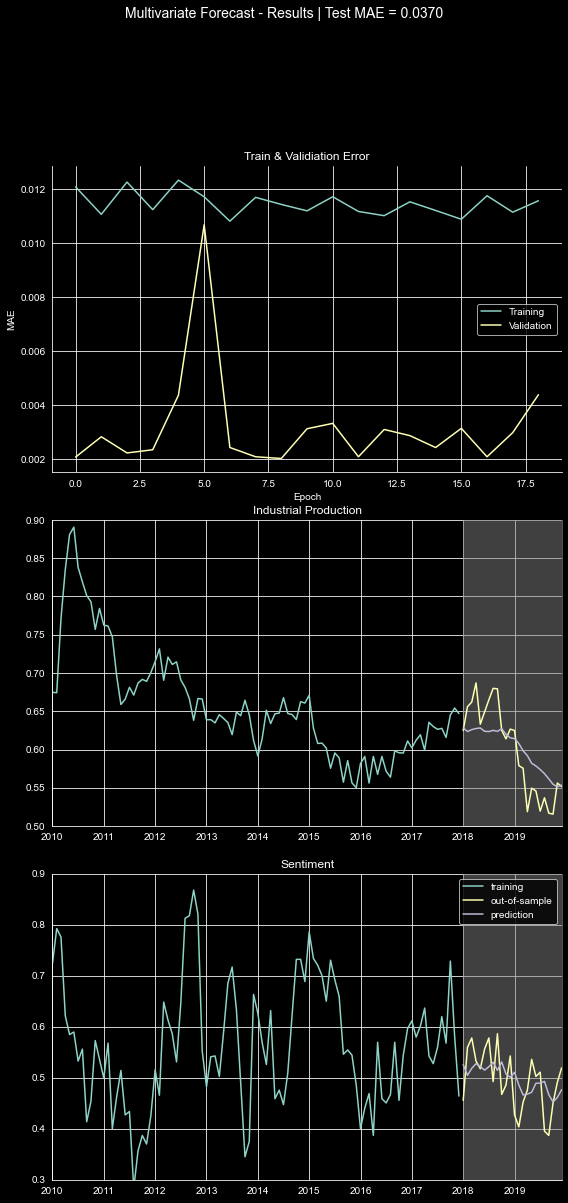

In [48]:
fig, axes = plt.subplots(3, 1, figsize=(8, 17))
pd.DataFrame(result.history).rename(columns={"loss": "Training",
                                              "val_loss": "Validation"}).plot(ax=axes[0], title="Train & Validiation Error")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MAE")
col_dict = {"ip": "Industrial Production", "sentiment": "Sentiment"}

for i, col in enumerate(y_test.columns, 1):
    y_train.loc["2010":, col].plot(ax=axes[i], label="training", title=col_dict[col])
    y_test[col].plot(ax=axes[i], label="out-of-sample")
    y_pred[col].plot(ax=axes[i], label="prediction")
    axes[i].set_xlabel("")

axes[1].set_ylim(.5, .9)
axes[1].fill_between(x=y_test.index, y1=0.5, y2=0.9, color="grey", alpha=.5)

axes[2].set_ylim(.3, .9)
axes[2].fill_between(x=y_test.index, y1=0.3, y2=0.9, color="grey", alpha=.5)

plt.legend()
fig.suptitle("Multivariate Forecast - Results | Test MAE = {:.4f}".format(test_mae), fontsize=14)
sb.despine()
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig(results_path / "multivariate_results", dpi=300);